### Return Attribution

This section introduces a technique for weighting samples to train machine learning algorithms. Highly overlapping results will have imbalanced weights compared to non-overlapping results. At the same time, labels associated with large absolute returns are more important than labels with negligible absolute returns. In short, we need to assign weights to observations using a function that considers both uniqueness and absolute returns.

When the label is a function of the return sign, the sample weight can be defined by the sum of contributing returns during the event's lifecycle [t_{i,0}, t_{i,1}].

$$\tilde{w_i} = \begin{vmatrix} \sum_{t = t_{i,0}}^{t_{i,1}} \frac{r_{t-1}, t}{c_{t}}\end{vmatrix}$$

$$w_i = \tilde{w_i} I \left( \sum_{j=1}^I \tilde{w_j}\right)$$

Therefore, $\sum_{i=1}^I w_i = I$. Since libraries generally assume the default weight of algorithmic parameters to be 1, we adjusted the magnitude of these weights so that their sum equals I.

The logic behind this method is that we want to express the weight of observations as a function of absolute log returns that can uniquely affect the observations. However, this method doesn't work when there are 'neutral' cases. In such cases, higher weights should be assigned to lower returns rather than lower weights. Ultimately, 'neutral' cases are unnecessary as they mean predicting '-1' or '1' with low confidence. The code below implements this method.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from quant_free.finml.labeling.labeling import *
from quant_free.finml.features.volatility import daily_volatility
from quant_free.finml.sample_weights.concurrency import *
from quant_free.finml.utils.multiprocess import *

start_date = '2000-01-01'
end_date = '2024-04-10'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date
)

[*********************100%***********************]  1 of 1 completed


In [2]:
vertical_barrier = add_vertical_barrier(
    data.index, 
    data['Close'], 
    num_days = 7 # expariation limit
)
vertical_barrier.head()

Date
2000-01-03   2000-01-10
2000-01-04   2000-01-11
2000-01-05   2000-01-12
2000-01-06   2000-01-13
2000-01-07   2000-01-14
Name: Date, dtype: datetime64[ns]

In [3]:
volatility = daily_volatility(
    data['Close'], 
    lookback = 60 # moving average span
)

In [4]:
triple_barrier_events = get_events(
    close = data['Close'],
    t_events = data.index[2:],
    pt_sl = [2, 1], # profit taking 2, stopping loss 1
    target = volatility, # dynamic threshold
    min_ret = 0.01, # minimum position return
    num_threads = 1, # number of multi-thread 
    vertical_barrier_times = vertical_barrier, # add vertical barrier
    side_prediction = None # betting side prediction (primary model)
)
triple_barrier_events.head()

,t1,trgt,pt,sl
Date,,,,
2000-01-07,2000-01-11,0.016797,2,1
2000-01-10,2000-01-12,0.026415,2,1
2000-01-11,2000-01-12,0.024043,2,1
2000-01-12,2000-01-13,0.031168,2,1
2000-01-13,2000-01-19,0.050703,2,1


In [5]:
labels = meta_labeling(
    triple_barrier_events, 
    data['Close']
)

In [6]:
labels.head()

,ret,trgt,bin
Date,,,
2000-01-07,-0.067839,0.016797,-1
2000-01-10,-0.108056,0.026415,-1
2000-01-11,-0.059973,0.024043,-1
2000-01-12,0.109677,0.031168,1
2000-01-13,0.101422,0.050703,0


In [7]:
triple_barrier_events['side'] = labels['bin']
triple_barrier_events.head()

,t1,trgt,pt,sl,side
Date,,,,,
2000-01-07,2000-01-11,0.016797,2,1,-1.0
2000-01-10,2000-01-12,0.026415,2,1,-1.0
2000-01-11,2000-01-12,0.024043,2,1,-1.0
2000-01-12,2000-01-13,0.031168,2,1,1.0
2000-01-13,2000-01-19,0.050703,2,1,0.0


In [8]:
num_threads = 1
num_conc_events = mp_pandas_obj(
    concurrent_events, 
    ('molecule', triple_barrier_events.index), 
    num_threads, 
    close_series_index = data['Close'].index, 
    label_endtime = triple_barrier_events['t1']
)

In [10]:
num_conc_events = num_conc_events.reindex(data['Close'].index).fillna(0)

In [12]:
triple_barrier_events[:-5]

,t1,trgt,pt,sl,side
Date,,,,,
2000-01-07,2000-01-11,0.016797,2,1,-1.0
2000-01-10,2000-01-12,0.026415,2,1,-1.0
2000-01-11,2000-01-12,0.024043,2,1,-1.0
2000-01-12,2000-01-13,0.031168,2,1,1.0
2000-01-13,2000-01-19,0.050703,2,1,0.0
...,...,...,...,...,...
2024-03-26,2024-04-02,0.018161,2,1,0.0
2024-03-27,2024-04-03,0.018151,2,1,-1.0
2024-03-28,2024-04-04,0.018013,2,1,0.0


In [13]:
from quant_free.finml.sample_weights.attribution import *

return_weights = weights_by_return(triple_barrier_events[:-5], data['Close'][:-5], num_threads = 1)

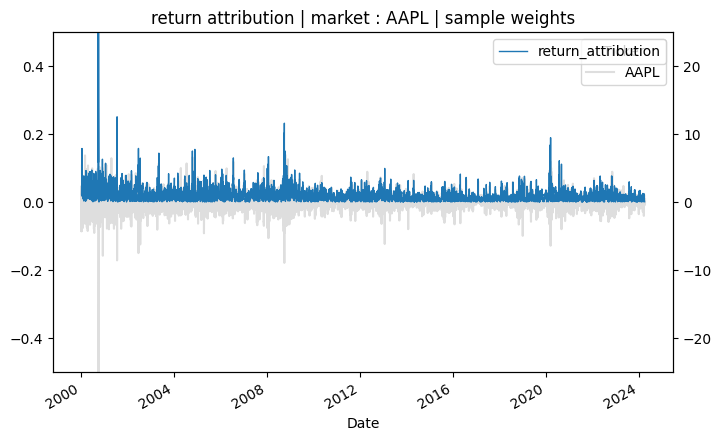

In [14]:
fig, ax = plt.subplots(figsize = (8, 5))
data['Close'].pct_change().plot(alpha = 0.75, ax = ax, color = 'lightgray')
plt.ylim([-0.5, 0.5])
plt.grid(False)

return_weights.plot(secondary_y=True, lw = 1)
plt.ylim([-25, 25])
plt.legend(['return_attribution'])
plt.grid(False)

plt.title('return attribution | market : AAPL | sample weights')
plt.show()